## Описание проекта
**Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».**

## Шаг 1. Открытие файла с данными и изучение общей информации

In [1]:
#прописываем нужные нам библиотеки 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import Decimal
import math
import numpy as np
from scipy import stats as st

In [2]:
df=pd.read_csv('/datasets/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В датаферйме заметны пропущенные значения, с каждый из них мы проработаем отдельно. Также разные регистры в названиях столбцов и не верный формат записи данных в столбце year_of_release.

In [4]:
#Выводим общую информацию датафрейма
def fun_date(data):
    print('**Общая информация датафрейма**',data.info())
    print('----------------------------')
    print('**Просмотр статистических данных**',data.describe())
    print('----------------------------')
    print('**Вывод рандомных строк датафрейма**',data.sample(n=3, random_state=1))
    print('----------------------------')
    print('**Вывод первых пяти строк датафрейма**',data.head(3))
    print('----------------------------')
    print('**Вывод количесва дубликатов датафрейма**',data.duplicated().sum())
    print('----------------------------')
print(fun_date(df))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
**Общая информация датафрейма** None
----------------------------
**Просмотр статистических данных**        Year_of_Release      NA_sales      EU_sales      JP_sales  \
count     16446.000000  16715.000000  16715.000000  16715.000000   
mean       2006.484616      0.263377      0.145060      0.077617   
std           5.877050      0.813604      0.503339      0.308853   
min        

In [5]:
#сводим значения к одному регистру
df.columns = map(str.lower, df.columns)
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


In [6]:
#проверяем где именно дубликаты
df.drop_duplicates().sum()

year_of_release    32998646.00
na_sales               4402.35
eu_sales               2424.67
jp_sales               1297.37
other_sales             791.32
critic_score         561190.00
dtype: float64

Большое количество дубликатов, но они все оправданы и трогать мы иих не будем, главное, чтобы не было дубликатов в столбце name

In [7]:
#смотрим где у нас пропущенные значения
df.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [8]:
df['year_of_release'] = df['year_of_release'].fillna(0)
df['year_of_release'] = np.ceil(df['year_of_release']).astype('int')

Пропущенное значение в годе выпуска заменим на ноль, допустив, что дата выхода не известна(была задумка заменить NaN на какое нибудь слово, но типы данных начали конфликтовать друг с другом)

In [9]:
#Меняем пропуски на среднее значение critic_score по жанрам
df['critic_score'] = df['critic_score'].fillna(0)
#df.groupby('genre')['critic_score'].transform('mean')
#df['critic_score_avg'] = df.groupby('genre')['critic_score'].transform('mean')
#df.loc[df['critic_score'] == 0, 'critic_score'] = df['critic_score_avg']

In [10]:
#Меняем пропуски на среднее значение user_score по жанрам
df['user_score'] = pd.to_numeric(df.user_score, errors='coerce')
df['user_score'] = df['user_score'].fillna(0)
#df.groupby('genre')['user_score'].transform('mean')
#df['user_score_avg'] = df.groupby('genre')['user_score'].transform('mean')
#df.loc[df['user_score'] == 0, 'user_score'] = df['user_score_avg']

In [11]:
df['rating'] = df['rating'].fillna(0)

Рейтинг заменим на ноль, условимся, что игру еще не оценили или нет данных

In [12]:
#высчитываем суммарный доход
df['cost'] = df['eu_sales']+df['jp_sales'] +df['na_sales'] +df['other_sales']

In [13]:
df.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,cost
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0.0,0,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52


Датафрейм обработан и приведен к нормальному виду, теперь с ним можно работать.

## Шаг 3. Проведите исследовательский анализ данных

###  Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

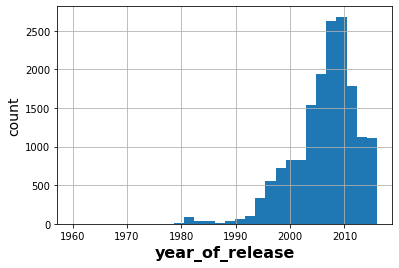

In [14]:
#count_game = df.groupby('year_of_release')['name'].count().head(5)
df['year_of_release'].hist(range=(1960,2016),bins=30)
plt.xlabel('year_of_release', fontweight='bold', fontsize=16)
plt.ylabel('count', fontweight='light', fontsize=14)
plt.grid(True)
plt.show()

Можно рассматривать данные, начиная с 1990 года.

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

             cost
platform         
PS2       1255.77
X360       971.42
PS3        939.65
Wii        907.51
DS         806.12


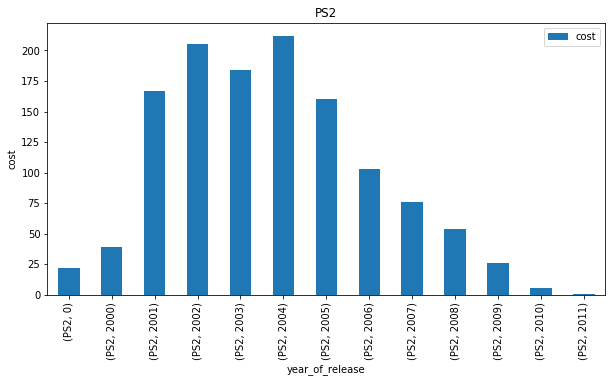

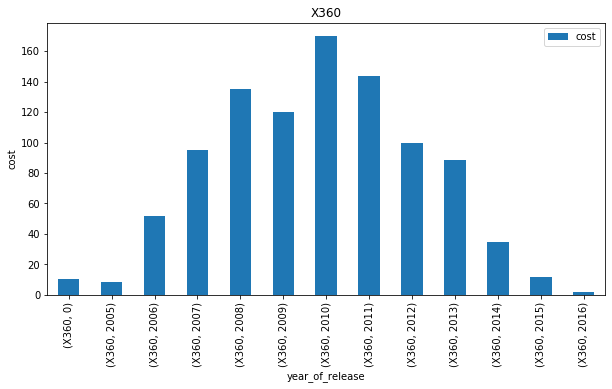

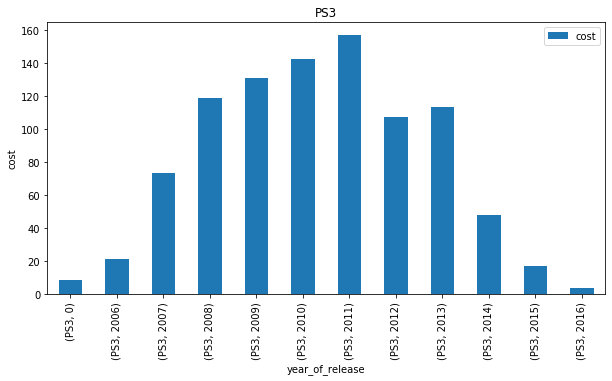

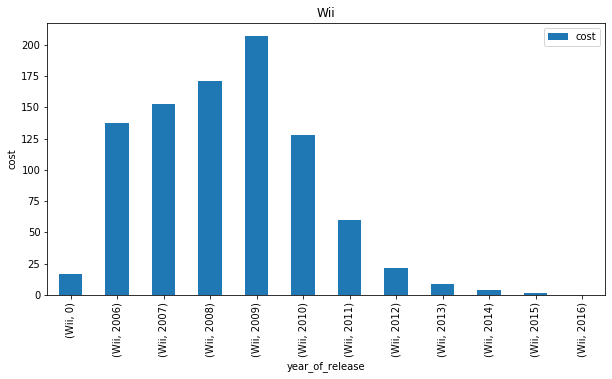

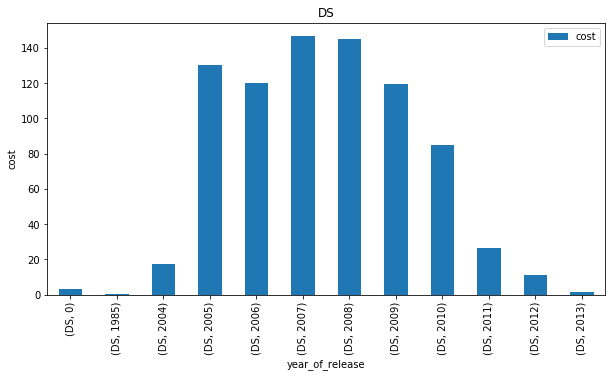

In [15]:
platcost = df.pivot_table(index=['platform'], values='cost', aggfunc='sum')
platcost = platcost.sort_values(by = 'cost',ascending = False)
print(platcost.head(5))

platcost1=df.pivot_table(index=['platform', 'year_of_release'], values='cost', aggfunc='sum')

for platform in platcost.head(5).index:
    platcost1.query('platform==@platform').plot.bar(figsize=(10, 5))
    plt.xlabel('year_of_release')
    plt.ylabel('cost')
    plt.title(platform)
    plt.show()



По графикам можно сделать вывод, что на каждой платформе пиковые продажи длятся в течении 5-7 лет. 

### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

In [35]:
#2012
actual_period = df.query('year_of_release > 2012')
actual_period.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,cost
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0.0,0.0,0,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,0.0,0.0,0,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


Так как по моим выводам платформа живет максимум пять лет, актуальным периодом, для оценки на 2017 год, можно брать, все что выше 2012 года.

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [17]:
platcost_period = actual_period.pivot_table(index=['platform'], values=['cost'], aggfunc='sum')
platcost_period = platcost_period.sort_values(by = 'cost',ascending = False)
print(platcost)

             cost
platform         
PS2       1255.77
X360       971.42
PS3        939.65
Wii        907.51
DS         806.12
PS         730.86
GBA        317.85
PS4        314.14
PSP        294.05
PC         259.52
3DS        259.00
XB         257.74
GB         255.46
NES        251.05
N64        218.68
SNES       200.04
GC         198.93
XOne       159.32
2600        96.98
WiiU        82.19
PSV         54.07
SAT         33.59
GEN         30.77
DC          15.95
SCD          1.86
NG           1.44
WS           1.42
TG16         0.16
3DO          0.10
GG           0.04
PCFX         0.03


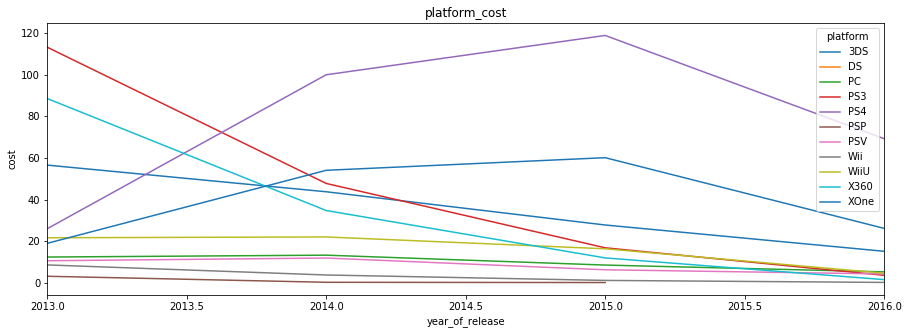

In [18]:
actual_period.pivot_table(index='year_of_release', columns = 'platform', values = 'cost', aggfunc = 'sum').plot.line(figsize=(15,5))
plt.xlabel('year_of_release')
plt.ylabel('cost')
plt.title('platform_cost')
plt.show()

Очевидно самые ходовые и распиариеные ps2,x360,Wii, которые имеют высокие продажи. Впринципе можно и отметить сами бренды PS,Xbox,Nintendo, у которых платформы нового поколения(PS4,XOne,WiiU) начинают набирать оборот. В упадке psp и консоли старого поколения, так как их время уже прошло...

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

            cost
platform        
PS4       314.14
PS3       181.43
XOne      159.32
3DS       143.25
X360      136.80
                           cost
platform year_of_release       
3DS      2013             56.57
         2014             43.76
         2015             27.78
         2016             15.14
DS       2013              1.54


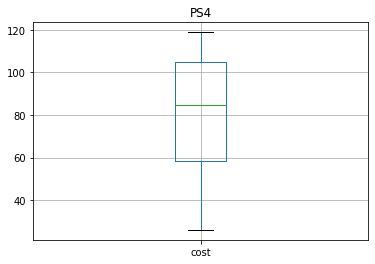

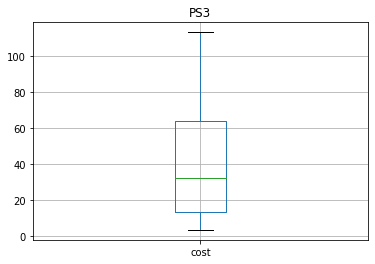

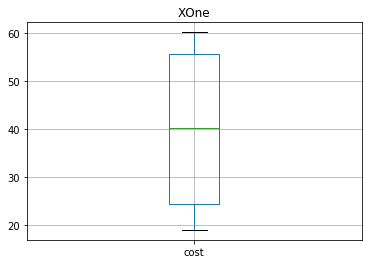

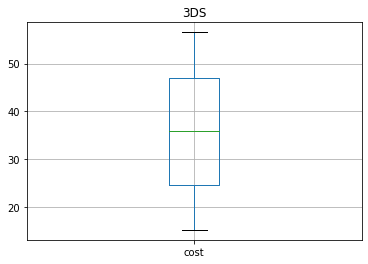

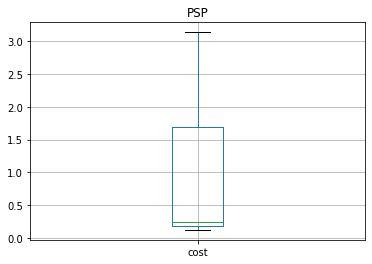

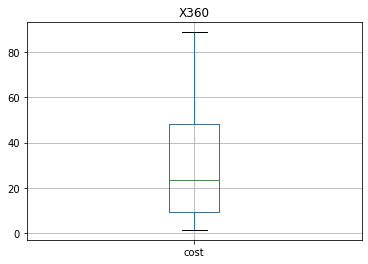

In [19]:
plat_game = actual_period.pivot_table(index=['platform'], values='cost', aggfunc='sum')
plat_game = plat_game.sort_values(by = 'cost',ascending = False)
print(plat_game.head(5))

d_35=actual_period.pivot_table(index=['platform', 'year_of_release'], values='cost', aggfunc='sum')
print(d_35.head())
platforms=['PS4', 'PS3', 'XOne', '3DS', 'PSP', 'X360']
for platform in platforms:
    d_35.query('platform==@platform').boxplot('cost')
    #plt.ylim()
    plt.title(platform)
    plt.show()

(-1.042, 22.102)

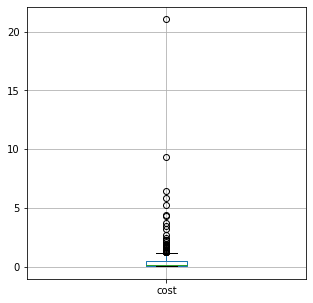

In [20]:
ps3 = actual_period.query('platform == "PS3"').boxplot('cost',figsize=(5,5))
plt.ylim()

(-0.8029999999999999, 17.083)

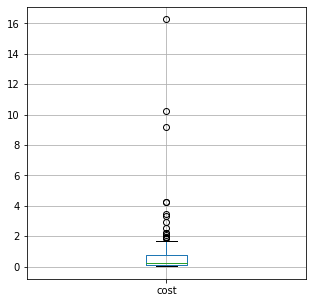

In [21]:
xbox360 = actual_period.query('platform == "X360"').boxplot('cost',figsize=(5,5))
plt.ylim()

Среди топовых платформ заметные выбросы у PS3 и xbox360, у остальны +/- отноисительно неплохо по прибыли.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


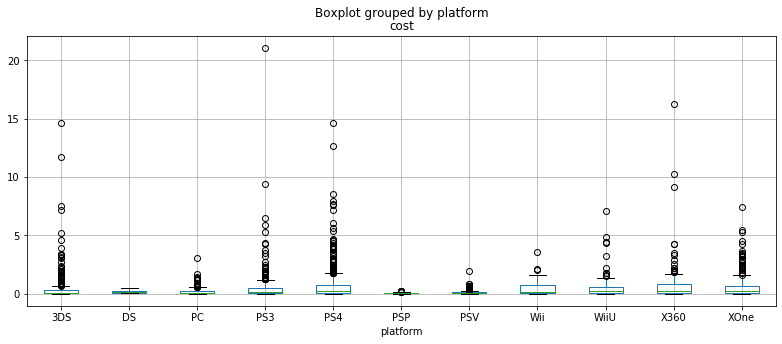

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(0, 2)

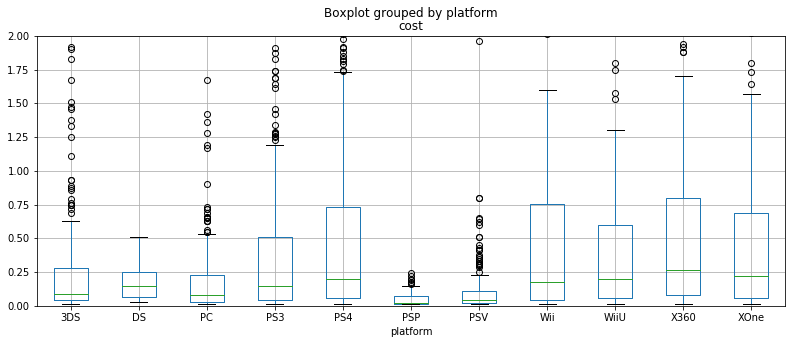

In [22]:
actual_period.boxplot('cost', by='platform', figsize=(13,5))
plt.show()
actual_period.boxplot('cost', by='platform', figsize=(13,5))
plt.ylim(0,2)

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
    

       critic_score  user_score   cost
16             97.0         8.2  21.05
69             71.0         2.6   9.36
126            86.0         4.3   6.46
149            95.0         9.1   5.86
180             0.0         0.0   5.27
...             ...         ...    ...
16558           0.0         0.0   0.01
16638           0.0         0.0   0.01
16674           0.0         0.0   0.01
16691           0.0         0.0   0.01
16710           0.0         0.0   0.01

[345 rows x 3 columns]


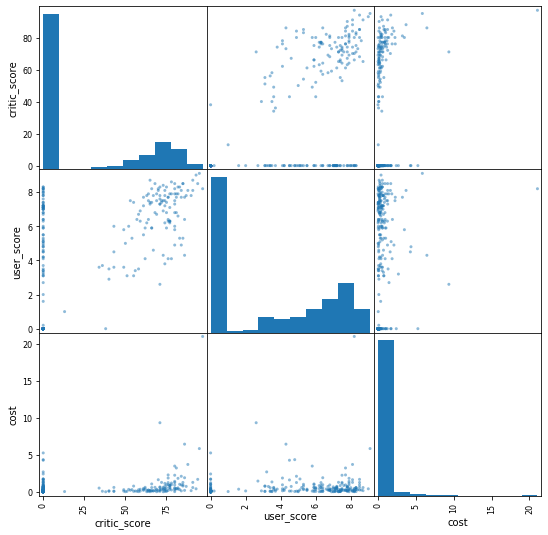

In [23]:
popular_platform = actual_period.query('platform=="PS3"')[['critic_score', 'user_score', 'cost']]
print(popular_platform)

pd.plotting.scatter_matrix(popular_platform, figsize=(9, 9)) 
plt.show()

In [24]:
popular_platform.corr()

,critic_score,user_score,cost
critic_score,1.000000,0.701261,0.279274
user_score,0.701261,1.000000,0.202091
cost,0.279274,0.202091,1.000000


Заметна сильная взаимосвязь между оценкой пользователей и оценкой критиков, либо пользователи слишком ведомые на критиков, либо действительно мнение о PS3 у всех положительное. 
Связь стоимости и оценкой не слишком заметна.

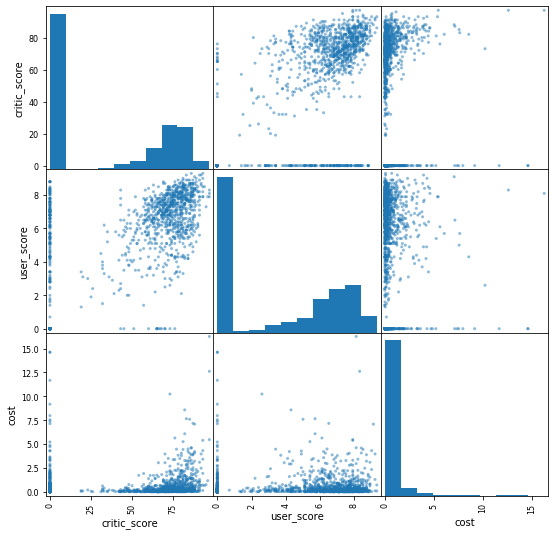

In [25]:
popular_platform_other = actual_period.query('platform !="PS3"')[['critic_score', 'user_score', 'cost']]
pd.plotting.scatter_matrix(popular_platform_other, figsize=(9, 9)) 
plt.show()

In [26]:
popular_platform_other.corr()

,critic_score,user_score,cost
critic_score,1.000000,0.835338,0.212720
user_score,0.835338,1.000000,0.143098
cost,0.212720,0.143098,1.000000


Аналогично и с другими приставками.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [27]:
game_genre = actual_period.pivot_table(index = 'genre', values='cost', aggfunc=['sum','count','median'])
game_genre.columns=['sum_cost','count_cost','median_cost']
#sum_cost - суммарные продажи по жанрам
#count_cost - количесво игр по жанрам
#median_cost - медианные продажи по жанрам
print(game_genre)


              sum_cost  count_cost  median_cost
genre                                          
Action          321.87         766        0.110
Adventure        23.64         245        0.030
Fighting         35.31          80        0.125
Misc             62.82         155        0.100
Platform         42.63          74        0.225
Puzzle            3.17          17        0.060
Racing           39.89          85        0.120
Role-Playing    145.89         292        0.125
Shooter         232.98         187        0.450
Simulation       21.76          62        0.100
Sports          150.65         214        0.240
Strategy         10.08          56        0.080


После подсчета медианных продаж стало видно, что жанр Shooter самый прибыльный эти игры продаются лучше всего. Самым убыточным жанром оказался Adventure.

## Шаг 4. Составьте портрет пользователя каждого региона
Определите для пользователя каждого региона (NA, EU, JP):
Самые популярные платформы (топ-5). Опишите различия в долях продаж.
Самые популярные жанры (топ-5). Поясните разницу.
Влияет ли рейтинг ESRB на продажи в отдельном регионе?

          na_sales
platform          
PS4         108.74
XOne         93.12
X360         81.66
PS3          63.50
3DS          38.20


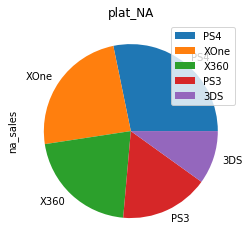

              na_sales
genre                 
Action          126.05
Shooter         109.74
Sports           65.27
Role-Playing     46.40
Misc             27.49


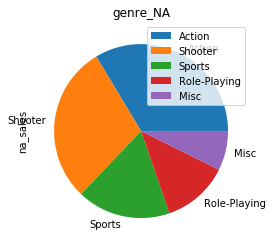

        na_sales
rating          
M         165.21
0          89.42
E          79.05
E10+       54.24
T          49.79


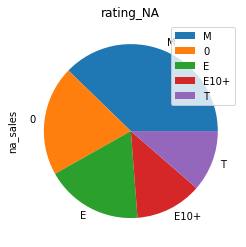

In [28]:
#NA
plat_NA = actual_period.pivot_table(index='platform', values='na_sales', aggfunc='sum')
plat_NA = plat_NA.sort_values(by = 'na_sales',ascending = False)
print(plat_NA.head())
print(plat_NA.head().plot.pie(subplots=True))
plt.title('plat_NA')
plt.show()

genre_NA = actual_period.pivot_table(index='genre', values='na_sales', aggfunc='sum')
genre_NA = genre_NA.sort_values(by = 'na_sales',ascending = False)
print(genre_NA.head())
print(genre_NA.head().plot.pie(subplots=True))
plt.title('genre_NA')
plt.show()

rating_NA = actual_period.pivot_table(index='rating', values='na_sales', aggfunc='sum')
rating_NA = rating_NA.sort_values(by = 'na_sales',ascending = False)
print(rating_NA.head())
print(rating_NA.head().plot.pie(subplots=True))
plt.title('rating_NA')
plt.show()

Северная Америка разделилась на два лагеря: xbox или PS, доли покупок практически не отличимы. По жанрам так же все ясно, играют в самые и универсальныесамые ходовые(экшн, шутер). По рейтингу тоже все ясно, пользователям интересны игры категории(М), тоесть старше 17 лет.

          eu_sales
platform          
PS4         141.09
PS3          67.81
XOne         51.59
X360         42.52
3DS          30.96


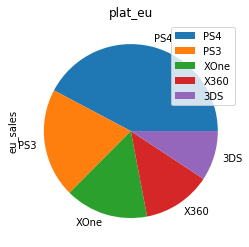

              eu_sales
genre                 
Action          118.13
Shooter          87.86
Sports           60.52
Role-Playing     36.97
Racing           20.19


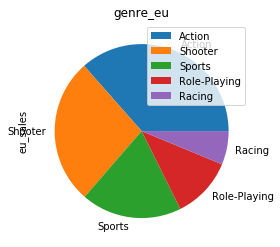

        na_sales
rating          
M         165.21
0          89.42
E          79.05
E10+       54.24
T          49.79


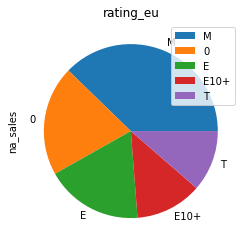

In [29]:
#eu
plat_eu = actual_period.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
plat_eu = plat_eu.sort_values(by = 'eu_sales',ascending = False)
print(plat_eu.head())
print(plat_eu.head().plot.pie(subplots=True))
plt.title('plat_eu')
plt.show()

genre_eu = actual_period.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
genre_eu = genre_eu.sort_values(by = 'eu_sales',ascending = False)
print(genre_eu.head())
print(genre_eu.head().plot.pie(subplots=True))
plt.title('genre_eu')
plt.show()

rating_eu = actual_period.pivot_table(index='rating', values='na_sales', aggfunc='sum')
rating_eu = rating_eu.sort_values(by = 'na_sales',ascending = False)
print(rating_eu.head())
print(rating_eu.head().plot.pie(subplots=True))
plt.title('rating_eu')
plt.show()

По привлекательности платформ, жанров и рейтинга в в Европе можно сказать тоже, что про Сев.Америку.


          jp_sales
platform          
3DS          67.81
PS3          23.35
PSV          18.59
PS4          15.96
WiiU         10.88


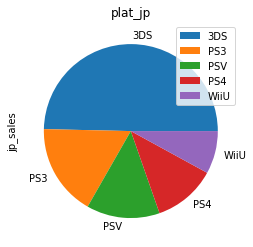

              jp_sales
genre                 
Role-Playing     51.04
Action           40.49
Misc              9.20
Fighting          7.65
Shooter           6.61


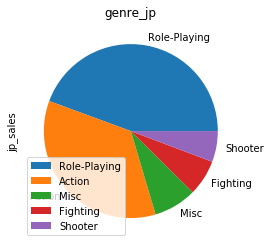

        na_sales
rating          
M         165.21
0          89.42
E          79.05
E10+       54.24
T          49.79


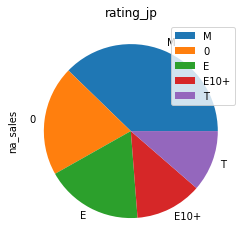

In [30]:
#jp
plat_jp = actual_period.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
plat_jp = plat_jp.sort_values(by = 'jp_sales',ascending = False)
print(plat_jp.head())
print(plat_jp.head().plot.pie(subplots=True))
plt.title('plat_jp')
plt.show()

genre_jp = actual_period.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
genre_jp = genre_jp.sort_values(by = 'jp_sales',ascending = False)
print(genre_jp.head())
print(genre_jp.head().plot.pie(subplots=True))
plt.title('genre_jp')
plt.show()

rating_jp = actual_period.pivot_table(index='rating', values='na_sales', aggfunc='sum')
rating_jp = rating_jp.sort_values(by = 'na_sales',ascending = False)
print(rating_jp.head())
print(rating_jp.head().plot.pie(subplots=True))
plt.title('rating_jp')
plt.show()

Внезапно, Япония выделилась со всего спика. Переносные платформы у них на хорошем счету и как выяснилось им нравится играть в ролиплей.По жанрам так же все ясно, играют в самые универсальные и ходовые(экшн, шутер). По рейтингу тоже все ясно, пользователям интересны игры категории(М), тоесть старше 17 лет.

**Шаг 5. Проверьте гипотезы
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.**

### Гипотеза 1 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

***Нулевая гипотеза - средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Альтернативная - средние пользовательские рейтинги платформ Xbox One и PC разные.***

In [31]:
xbox_avg_rate=actual_period.query('platform == "XOne"')['user_score']                                                   
pc_avg_rate=actual_period.query('platform == "PC"')['user_score']


In [32]:
alpha=0.05
results = st.ttest_ind(xbox_avg_rate, pc_avg_rate, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
  

p-значение: 0.24400999542744453
Не получилось отвергнуть нулевую гипотезу


Не получилось оправергнуть гипотезу, тк большинство игр выходит на все платформы и пользователи из разных платформ могут ставить рейтинг играм, в которые они оба уже играли.

### Гипотеза 2 - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

Нулевая гипотеза - средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.
Алтернативная гипотеза - средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [33]:
action_avg_rate=actual_period.query('genre == "Action"')['user_score']                                                   
sports_avg_rate=actual_period.query('genre == "Sports"')['user_score']

In [34]:
alpha=0.05
results = st.ttest_ind(action_avg_rate, sports_avg_rate, equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.051807560603891564
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза подтверждена, что странно...т.к. жанры абсолютно разные.

## Шаг 6. Напишите общий вывод

Можно смело заявить, что стоит развивать индустрию жанров экшн и шутеры в регионах Сев.Америки и Европе, потому что по этим жанрам идет основная прибыль. Также стоит отметить, что в этих регионах любят стационарные платформы и стоит вкладыываться именно в них. В отличии от Японии, которая фанатеет от РП и ММО на переносных гаджетах, наверное ключевую роль играет менталитет каждого континента.